# <font color=#DF3A01> **Modelo de predicción de aceptación de préstamos hipotecarios** </font>

<img src="im.png" width="1000" height="1000"/>

In [1]:
# Importamos las librerías
import warnings # Para el manejo de warnings
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns # Para gráficos estadísticos
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Para estandarizar 
from sklearn.metrics import accuracy_score, classification_report 
from sklearn import metrics
from termcolor import colored # Para los colores del texto
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import VotingClassifier
import torch
import torch.nn.functional as F

# Sobre term color https://pypi.org/project/termcolor/

In [2]:
# Fijamos la semilla 
random_seed = 666 
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

In [3]:
# Cargamos la base de datos
loan_data = pd.read_csv('Loan_Data.csv')
# No necesitamos el ID
loan_data.drop(['Loan_ID'], axis = 1 , inplace = True)
# Un vistazo a la base
# https://www.kaggle.com/code/mohamedkhaledmahmoud/loan-eligibility-prediction-model/input
loan_data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


# <font color=#04B4AE> Información sobre los datos </font>

Esta base de datos contiene un conjunto de datos de predicción de préstamos. Proporciona información sobre **614** registros de solicitudes de préstamos y  **12** variables. Queremos predecir la variable **LoanStatus** a partir del resto de las variables.

| No. | Variable          | Descripción                              | Tipo de variable       |
|:---:|:-------------------|:------------------------------------------|:-----------------|
|  1  | Gender             | 👫 Gender (Male/Female)                   | Categórica     |
|  2  | Married            | 💍 Married (Y/N)                          | Categórica      |
|  3  | Dependents         | 👨‍👩‍👧‍👦 Dependents   (0,1,2,+3)                           | Categórica      |
|  4  | Education          | 🎓 Education (Graduate/Undergraduate)     | Categórica      |
|  5  | SelfEmployed       | 💼 Self-employed (Y/N)                    | Categórica      |
|  6  | ApplicantIncome    | 💰 Applicant's Income                     | Numérica  |
|  7  | CoapplicantIncome  | 💵 Coapplicant's Income (aval)                  | Numérica    |
|  8  | LoanAmount         | 💸 Loan Amount (en miles)             | Numérica    |
| 9  | LoanAmountTerm     | ⏰ Loan Term (en meses)                  | Numérica    |
| 10  | CreditHistory      | 📜 Credit History   (Cumple con las pautas)                      | Binaria (1/0)    |
| 11  | PropertyArea       | 🏡 Property Area (Urban/Semi-Urban/Rural) | Categórica      |
| 12  | LoanStatus         | 📋 Loan Status (Approved/Not Approved)    | Categórica      |

In [8]:
# Con .info() se obtiene información básica de los datos, incluido el tipo de índice y las columnas, los valores no nulos y el uso de memoria.

print(loan_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB
None


### <font color=#0080FF> Valores faltantes </font>
**Opciones**
1. Eliminarlos
    - No es ideal, ya que los valores faltantes pueden dar lugar a análisis sesgados y predicciones inexactas.
2. Reasignarlos nuevos valores (Usando técnicas específicas)
    - Imputación (Y):
        - Reemplace los valores faltantes con valores estimados o calculados en función de los datos disponibles. Esto se puede hacer usando varios métodos como:
            1. **Media/mediana:** Reemplace con el promedio (media) o el valor medio (mediana) para datos numéricos.
            2. **Moda:** Reemplazar con el valor más frecuente.

In [11]:
## Usaremos la moda para Credit_History 
# [0] Selecciona sólo la primer moda
loan_data["Credit_History"] = loan_data["Credit_History"].fillna(loan_data["Credit_History"].mode()[0])

## Para LoanAmount usaremos la media
loan_data["LoanAmount"] = loan_data["LoanAmount"].fillna(loan_data["LoanAmount"].mean())

## Moda para Loan_Amount_Term
loan_data["Loan_Amount_Term"] = loan_data["Loan_Amount_Term"].fillna(loan_data["Loan_Amount_Term"].mode()[0])

# Moda para todas las binarias y categóticas
loan_data["Gender"] = loan_data["Gender"].fillna(loan_data["Gender"].mode()[0])
loan_data["Married"] = loan_data["Married"].fillna(loan_data["Married"].mode()[0])
loan_data["Dependents"] = loan_data["Dependents"].fillna(loan_data["Dependents"].mode()[0])
loan_data["Self_Employed"] = loan_data["Self_Employed"].fillna(loan_data["Self_Employed"].mode()[0])

In [13]:
# Revisamos que ya no haya datos faltantes
null_counts = loan_data.isnull().sum()
print(null_counts)
print("_________________________________________________________________")
print(colored(f" Hay {null_counts.sum()} datos faltantes en la base.", "light_blue", attrs=['reverse']))

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
_________________________________________________________________
 Hay 0 datos faltantes en la base.


### <font color=#0080FF> Outliers </font>

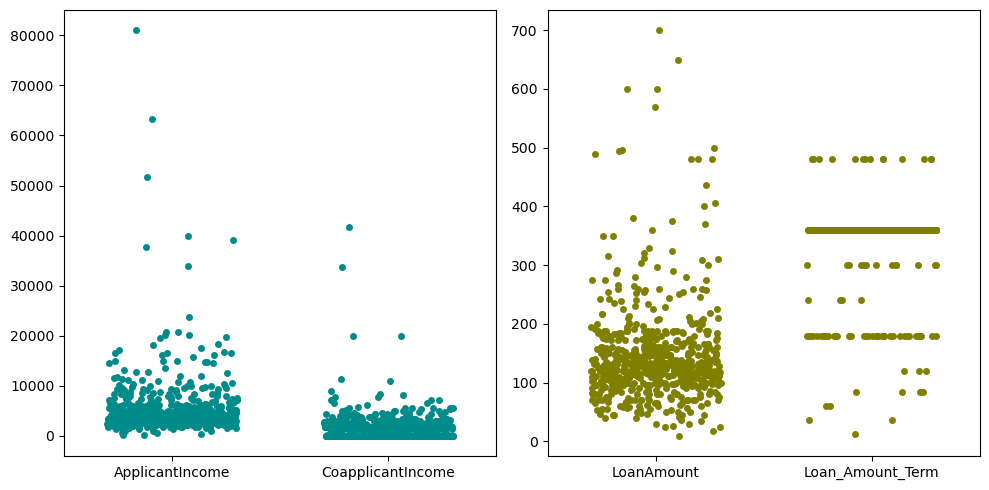

In [16]:
# Tamaño de la figura (10 ancho x10 alto pulgadas)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Variables que pueden tener Outliers (numéricas)
outliers1 = loan_data.get(["ApplicantIncome", "CoapplicantIncome"])
outliers2 = loan_data.get(["LoanAmount", "Loan_Amount_Term"])

# Add outliers to the plot
sns.stripplot(data=outliers1, ax=axs[0], color="darkcyan", jitter=0.3, size=5)
#axs[0].set_title("Applicant Income / Coapplicant Income Outliers")
#axs[0].set_ylabel("Income")
sns.stripplot(data=outliers2, ax=axs[1], color="olive", jitter=0.3, size=5)
#axs[1].set_title(" Sobre el préstamo Outliers")
#axs[1].set_ylabel("")


# Set the axis labels and title


# Mostrar la figura
plt.tight_layout()  # Ajustar el espacio entre gráficas
plt.show()

In [18]:
# Removemos los Outliers (antes de estandarizar los datos porque estos pueden
#influir en nuestras estadísticas como la media, varianza, etc)

loan_data = loan_data[loan_data['ApplicantIncome']<=40000]
loan_data = loan_data[loan_data['CoapplicantIncome']<20000]

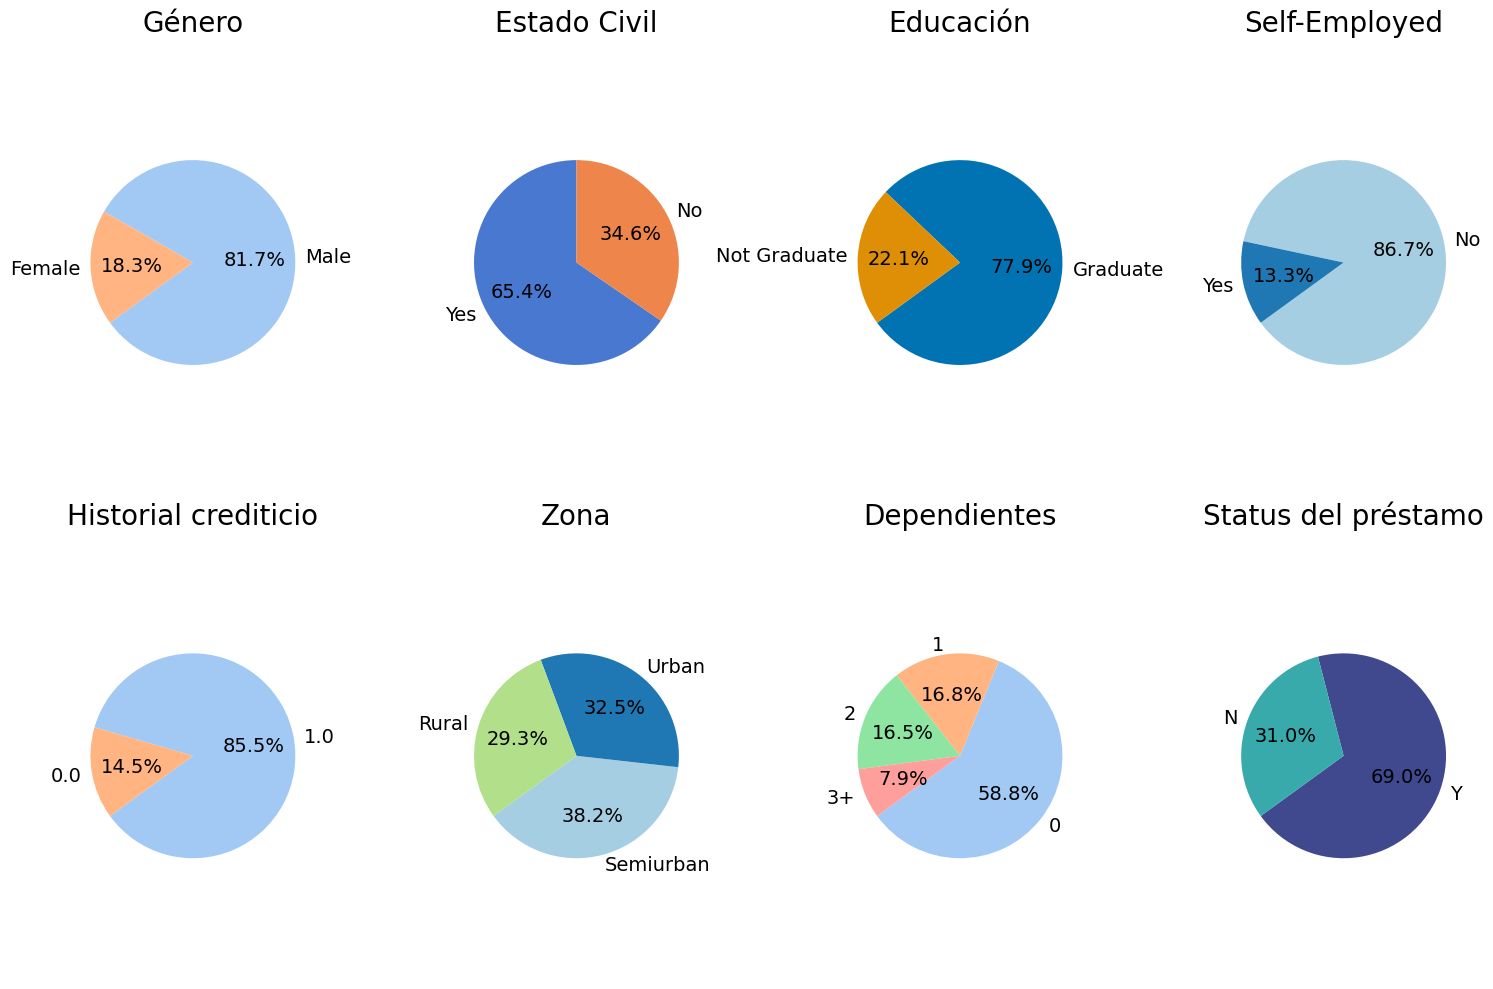

In [20]:
# Contar valores de estado civil y género, incluyendo NaN
EstadoCivil = loan_data.Married.value_counts(dropna=False)
Genero = loan_data.Gender.value_counts(dropna=False)
Educacion= loan_data.Education.value_counts(dropna=False)
SelfEmployed = loan_data.Self_Employed.value_counts(dropna=False)
HistCred = loan_data.Credit_History.value_counts(dropna= False)
StatusPrestamo= loan_data.Loan_Status.value_counts(dropna=False)
Zona = loan_data.Property_Area.value_counts(dropna=False)
Dependientes =loan_data.Dependents.value_counts(dropna=False)


# Tamaño de la figura (15x10 pulgadas)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))


# Gráfico de pastel para Género
axs[0,0].pie(Genero, 
           labels=Genero.index, 
           startangle=216, 
           autopct='%1.1f%%', 
           colors=sns.color_palette("pastel", len(Genero)),
           textprops={'fontsize': 14})
axs[0,0].axis('equal')  # Para mantener la forma circular
axs[0,0].set_title('Género', fontsize=20)

# Gráfico de pastel para Estado Civil
axs[0,1].pie(EstadoCivil, 
           labels=EstadoCivil.index, 
           startangle=90, 
           autopct='%1.1f%%', 
           colors=sns.color_palette("muted", len(EstadoCivil)),
           textprops={'fontsize': 14})
axs[0,1].axis('equal')  # Para mantener la forma circular
axs[0,1].set_title('Estado Civil', fontsize=20)

# Gráfico de pastel para Educación
axs[0,2].pie(Educacion, 
           labels=Educacion.index, 
           startangle=216, 
           autopct='%1.1f%%', 
           colors=sns.color_palette("colorblind", len(Educacion)),
           textprops={'fontsize': 14})
axs[0,2].axis('equal')  # Para mantener la forma circular
axs[0,2].set_title('Educación', fontsize=20)

# Gráfico de pastel para Self_Employed
axs[0,3].pie(SelfEmployed, 
           labels=SelfEmployed.index, 
           startangle=216, 
           autopct='%1.1f%%', 
           colors=sns.color_palette("Paired", len(SelfEmployed)),
           textprops={'fontsize': 14})
axs[0,3].axis('equal')  # Para mantener la forma circular
axs[0,3].set_title('Self-Employed', fontsize=20)

# Gráfico de pastel para Cumple con Historial Crediticio
axs[1,0].pie(HistCred, 
           labels=HistCred.index, 
           startangle=216, 
           autopct='%1.1f%%', 
           colors=sns.color_palette("pastel", len(HistCred)),
           textprops={'fontsize': 14})
axs[1,0].axis('equal')  # Para mantener la forma circular
axs[1,0].set_title('Historial crediticio', fontsize=20)

axs[1,1].pie(Zona, 
           labels=Zona.index, 
           startangle=216, 
           autopct='%1.1f%%', 
           colors=sns.color_palette("Paired", len(Zona)),
           textprops={'fontsize': 14})
axs[1,1].axis('equal')  # Para mantener la forma circular
axs[1,1].set_title('Zona', fontsize=20)

# Gráfico de pastel para Cumple con Historial Crediticio
axs[1,2].pie(Dependientes, 
           labels=Dependientes.index, 
           startangle=216, 
           autopct='%1.1f%%', 
           colors=sns.color_palette("pastel", len(Dependientes)),
           textprops={'fontsize': 14})
axs[1,2].axis('equal')  # Para mantener la forma circular
axs[1,2].set_title('Dependientes', fontsize=20)

# Gráfico de pastel para Status del prestamo
axs[1,3].pie(StatusPrestamo, 
           labels=StatusPrestamo.index, 
           startangle=216, 
           autopct='%1.1f%%', 
           colors=sns.color_palette("mako", len(StatusPrestamo)),
           textprops={'fontsize': 14})
axs[1,3].axis('equal')  # Para mantener la forma circular
axs[1,3].set_title('Status del préstamo', fontsize=20)


# Mostrar los gráficos
#plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.tight_layout()  # Ajustar el espacio entre gráficos
plt.show()

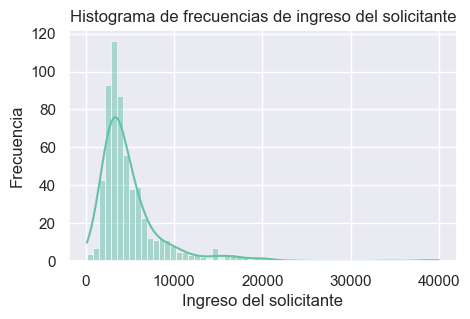

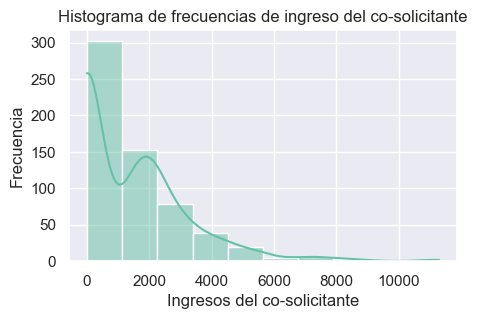

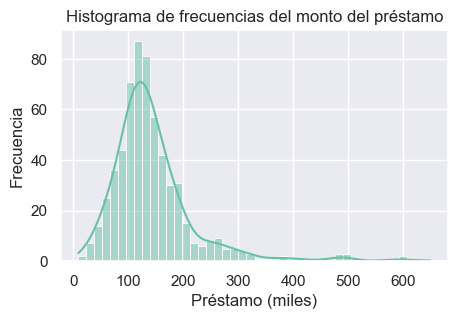

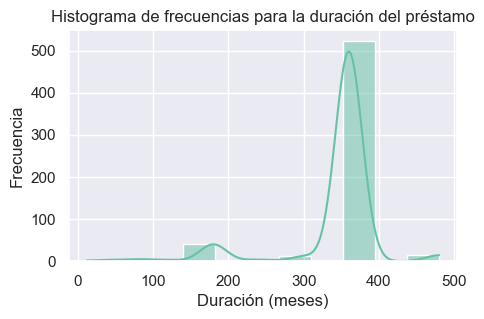

In [22]:
# Histograma para las variables numéricas
# Con .set_theme podemos fijar los colores que queremos usar
sns.set_theme(palette="Set2")


# Histograma para INGRESOS DEL APLICANTE
plt.figure(figsize=(5, 3))
# kernel density estimate (KDE) para ajustatar una densidad continua continuous probability (en una o más dimensiones)
sns.histplot(data=loan_data,x="ApplicantIncome", kde=True)
plt.title('Histograma de frecuencias de ingreso del solicitante')
plt.xlabel('Ingreso del solicitante')
plt.ylabel('Frecuencia')

# Histograma para INGRESOS DEL CO-APLICANTE
plt.figure(figsize=(5, 3))
sns.histplot(data=loan_data, x="CoapplicantIncome", kde=True, bins = 10)
plt.title('Histograma de frecuencias de ingreso del co-solicitante')
plt.xlabel('Ingresos del co-solicitante')
plt.ylabel('Frecuencia')

# Histograma para LOAN AMOUNT
plt.figure(figsize=(5, 3))
sns.histplot(data=loan_data, x="LoanAmount", kde=True)
plt.title('Histograma de frecuencias del monto del préstamo')
plt.xlabel('Préstamo (miles)')
plt.ylabel('Frecuencia')

# Histograma para la duración del préstamo
plt.figure(figsize=(5, 3))
sns.histplot(data=loan_data, x="Loan_Amount_Term", kde=True)
plt.title('Histograma de frecuencias para la duración del préstamo')
plt.xlabel('Duración (meses)')
plt.ylabel('Frecuencia')


plt.show()

 Hay correlación positiva entre LoanAmount y ApplicantIncome.
_____________________________________________________________


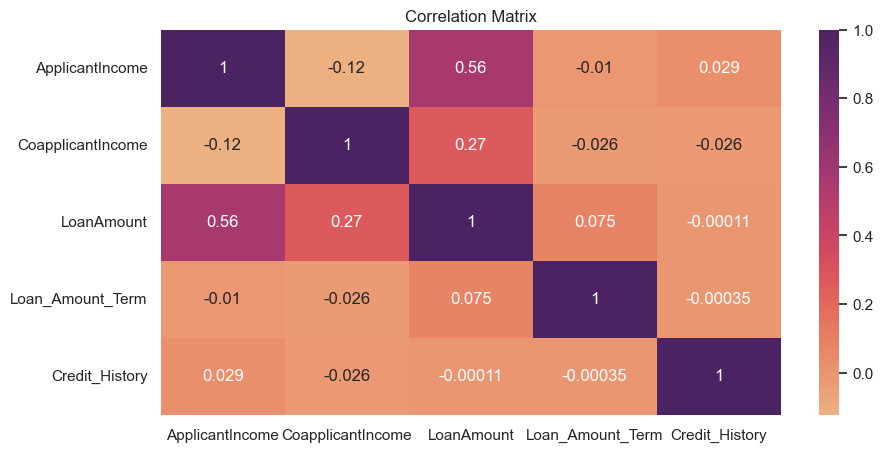

In [24]:
# Matrix de correlaciones
correlation_matrix = loan_data.corr(numeric_only=True)
print(colored(f" Hay correlación positiva entre LoanAmount y ApplicantIncome.", "light_blue", attrs=['reverse']))
print("_____________________________________________________________")
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='flare') # annot: write the data value in each cell
plt.title('Correlation Matrix')
plt.show()

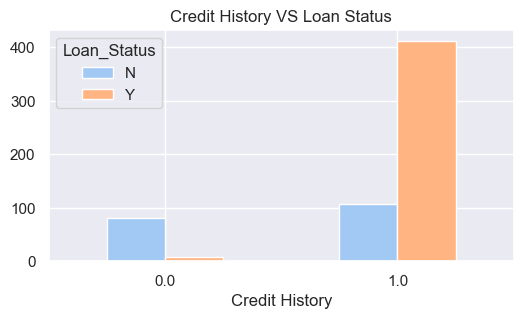

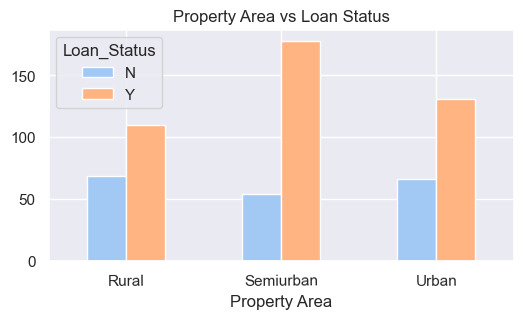

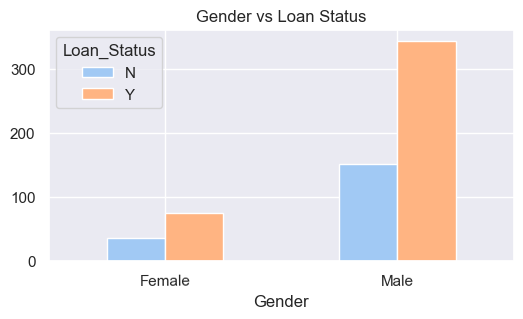

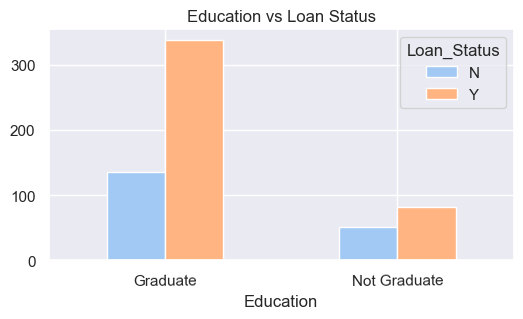

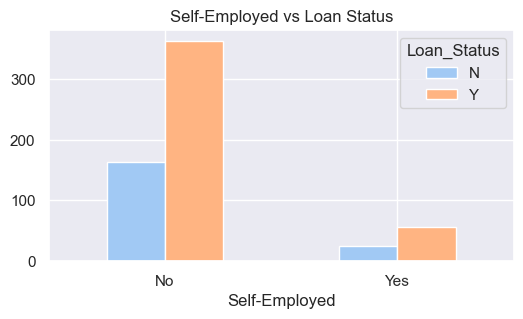

In [26]:
## Buen historial vs Estado del préstamo
# .crosstab() crea una tabla que muestra la relacional entre dos variables categorícas

HCLS = pd.crosstab(loan_data.Credit_History, loan_data.Loan_Status)#div(HCLS.sum(axis=1), axis=0)
colores = sns.color_palette("pastel", len(HCLS.columns))
HCLS.plot(kind='bar', figsize=(6,3),color=colores)
plt.title('Credit History VS Loan Status')
plt.xlabel('Credit History')
plt.xticks(rotation=0.5)

PALS = pd.crosstab(loan_data.Property_Area, loan_data.Loan_Status)#.div(PALS.sum(axis=1), axis=0)
colores = sns.color_palette("pastel", len(PALS.columns))
PALS.plot(kind='bar', figsize=(6,3),color=colores)
plt.title('Property Area vs Loan Status')
plt.xlabel('Property Area')
plt.xticks(rotation=0.5)

GLS = pd.crosstab(loan_data.Gender, loan_data.Loan_Status)#.div(GLS.sum(axis=1), axis=0)
colores = sns.color_palette("pastel", len(GLS.columns))
GLS.plot(kind='bar', figsize=(6,3),color=colores)
plt.title('Gender vs Loan Status')
plt.xlabel('Gender')
plt.xticks(rotation=0.5)

EDULS = pd.crosstab(loan_data.Education, loan_data.Loan_Status)#.div(EDULS.sum(axis=1), axis=0)
colores = sns.color_palette("pastel", len(EDULS.columns))
EDULS.plot(kind='bar', figsize=(6,3),color=colores)
plt.title('Education vs Loan Status')
plt.xlabel('Education')
plt.xticks(rotation=0.5)

SELS = pd.crosstab(loan_data.Self_Employed, loan_data.Loan_Status)#.div(SELS.sum(axis=1), axis=0)
colores = sns.color_palette("pastel", len(SELS.columns))
SELS.plot(kind='bar', figsize=(6,3),color=colores)
plt.title('Self-Employed vs Loan Status')
plt.xlabel('Self-Employed')
plt.xticks(rotation=0.5)
plt.show()

### <font color=#FFBF00>  Preparación de los datos </font>

##### <font color=#0080FF>  Codificación de variables categóricas </font>
El método de codificación Label Encoding es una forma sencilla de asignar valores numéricos a las diferentes categorías de una variable categórica. Sin embargo, presenta una limitación importante, y es que estos valores numéricos pueden ser malinterpretados por algunos algoritmos de aprendizaje automático. Por ejemplo, si codificamos cuatro ciudades con los valores 0, 1, 2 y 3, es posible que un algoritmo interprete erróneamente que, por ejemplo, la ciudad correspondiente al valor 3 tiene -según algún criterio- un valor tres veces mayor que la ciudad con el valor 1, lo cual no es cierto.

Una alternativa al Label Encoding es el método de codificación llamado **One Hot Encoding**. Esta estrategia consiste en crear una columna binaria (que solo puede contener los valores 0 o 1) para cada valor único que exista en la variable categórica que estamos codificando, y marcar con un 1 la columna correspondiente al valor presente en cada registro, dejando las demás columnas con un valor de 0. Por ejemplo, en el caso de la variable "sex" de los pasajeros del Titanic, One Hot Encoding crearía dos columnas binarias (una para el valor "male" y otra para el valor "female"). Para cada pasajero, se asignaría un valor de 1 a la columna correspondiente a su género y un valor de 0 a la columna del género opuesto. De esta manera, cada registro queda representado por un vector binario que indica la presencia o ausencia de cada valor categórico, y se evita la posibilidad de que los algoritmos malinterpreten los valores numéricos asignados por Label Encoding.

Se puede usar p-1 columnas para definir parámetros si se tienen  etiquetas únicas. Por ejemplo, si solo mantenemos la columna "female" y eliminamos la columna "male", entonces también podemos transmitir toda la información como cuando la etiqueta es 1, significa mujer y cuando la etiqueta es 0, significa hombre. De esta manera podemos codificar los datos categóricos y reducir también la cantidad de parámetros.

Una desventaja de este método es que estamos aumentando la dimensionalidad del conjunto de datos lo que puede resultar problemático si el número de muestras de las que se dispone no es suficientemente elevado.


Fuentes:

https://interactivechaos.com/es/manual/tutorial-de-machine-learning/one-hot-encoding
https://www.geeksforgeeks.org/ml-one-hot-encoding/

In [30]:
# Primero hacemos variables dummies (las que agregamos)
loan_data = pd.get_dummies(loan_data)
# Quitamos las que se deducen de las otras por tanto son innecesarias 
loan_data = loan_data.drop(['Gender_Female', 
                            'Married_No', 
                            'Education_Not Graduate',
                            'Self_Employed_No', 
                            'Loan_Status_N', 'Dependents_3+', 'Property_Area_Urban'], axis = 1) # axis = 1 columna
Nombres = {'Gender_Male': 'Gender', 
            'Married_Yes': 'Married', 
            'Education_Graduate': 'Education',    
            'Self_Employed_Yes': 'Self_Employed',
            'Loan_Status_Y': 'Loan_Status'}
# Renombramos
loan_data.rename(columns=Nombres, inplace=True)
column_names = loan_data.columns.tolist()
# Codificamos a 0 y 1 las variables 
col_bool = ['Credit_History', 'Gender', 'Married', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Education', 'Self-Employed' ] 
loan_data[column_names[4:]] = loan_data[column_names[4:]].astype(int)
# 1 = Male
# 1 = Graduated
# 1 = Married
# 1 = Buen historial
# 1 = Su propio jefe
nombres_columnas = loan_data.columns.tolist()

In [32]:
len(nombres_columnas)

15

In [34]:
# Variable a predecir (respuestas)
Y = loan_data['Loan_Status'].to_numpy()
# Matriz de covariables (predictores)
X_data = loan_data.drop(columns=['Loan_Status'])
X = X_data.to_numpy() 
# Print the shapes of X and Y to verify the splitting
print("Tamaño of X:", X.shape)
print("Tamaño of Y:", Y.shape)

Tamaño of X: (607, 14)
Tamaño of Y: (607,)


## <font color=#DF0174>  Modelos </font>

### <font color=#21610B> Regresión logística Ridge/ Lasso </font>

Recordemos que el modelo de regresión logística está dado (en el caso más simple) por 
$$p_i = \frac{e^{(\beta_0+\beta_1x_i)}}{1+e^{(\beta_0+\beta_1x_i)}}$$
Que puede ser linealizada con la transformación
$$ln(p_i/1-p_i)=\beta_0+\beta_1x_i$$
Y la función log-verosimilitud está dada por 
$$ln(L)=\sum_{i=1}^nln(1-p_i)+y_iln(p_i/1-p_i)$$
Vamos a minimizar su negativo, al cual denotaremos por $L_{log}$ al cual llamaremos "función de log-pérdida". La regularizacion ridge en este caso está dada por 
$$L_{log}+\lambda \sum_{j=1}^p\beta_j^2$$
O con Lasso 
$$L_{log}+\lambda \sum_{j=1}^p |\beta_j|$$
Fuentes: 
- https://compgenomr.github.io/book/logistic-regression-and-regularization.html 
- https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

### <font color=#21610B> Ridge Classifier </font>
Este método de clasificación convierte a la variable respuesta en una que toma valores {-1,1} y trata el problema como una regresión Ridge usual. La clase predicha corresponde al signo de la predicción del regresor. En este caso minimizamos:
$$||y-X\beta||^2+\alpha ||\beta||^2$$

- Esta forma de clasificar puede llegar a ser más rápida que, por ejemplo, la regresión logística y en la práctica se obtienen resultados similares.
- La penalización $\alpha$ corresponde a $1/(2C)$ en otros modelos lineales como LogisticRegression, es decir, un valor más alto de $C$ significa menos regularización (y viceversa).

Fuente:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html 


In [38]:
#------------- Regresión logística----------------
#-------------------------------------------------
logistic = LogisticRegression(solver='liblinear', max_iter=1000)
parametros = {
    'penalty' : ['l1','l2'],
    'C' : [0.1, 0.01, 1e-2, 1e-3, 1e-4 , 1 , 10, 1e+2, 1e+3, 1e+4]
}
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=logistic, param_grid=parametros, scoring='accuracy', cv=10, n_jobs = -1)
# Usamos los datos de validación
grid_search.fit(X, Y)
#Encontrar el mejor
L_best = grid_search.best_estimator_

In [39]:
# Ver el mejor puntaje (R^2 promedio) obtenido durante la validación cruzada
print(f"Mejor R^2 promedio (score): {grid_search.best_score_:.4f}")

Mejor R^2 promedio (score): 0.8107


In [42]:
# Encontramos los parámetros del modelo seleccionado
best_params = grid_search.best_params_
best_params['C'], best_params['penalty']

(0.1, 'l1')

In [44]:
# Ajustamos el modelo seleccionado a los datos de entrenamiento
logistic_s = LogisticRegression(solver='liblinear', C = best_params['C'], penalty = best_params['penalty'], max_iter=1000)
logistic_s.fit(X,Y)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')

In [46]:
loo = LeaveOneOut()
cv_scores = cross_val_score(logistic_s, X, Y, cv=10)

In [48]:
accuracy_LCV = cv_scores.mean()

In [50]:
# Calculamos el accuracy en los datos de testeo
#accuracy_L = logistic_s.score(X_test, Y_test)
accuracy_LT = logistic_s.score(X, Y)
print(colored(f"Accuracy en el conjunto de entrenamiento:{accuracy_LT}", "magenta", attrs=['reverse'] ))
print(colored(f"Accuracy cv:{accuracy_LCV}", "light_magenta", attrs=['reverse'] ))

Accuracy en el conjunto de entrenamiento:0.8105436573311368
Accuracy cv:0.8106830601092895


In [52]:
y_pred = logistic_s.predict(X)
np.sum(y_pred)

518

In [54]:
# Ajustar el modelo de regresión Logística con L1
model = LogisticRegression(penalty='l1', solver='liblinear', C = grid_search.best_params_['C'])
model.fit(X, Y)

# Obtener los coeficientes
coefficients = model.coef_[0] #no incluye el intercepto
print("Coeficientes del modelo:", coefficients)
selected_indices = np.where(np.abs(coefficients) > 1e-5)[0]
columnas_selected = [nombres_columnas[i] for i in selected_indices]
print(colored(f" Variables seleccionadas  {columnas_selected}","light_yellow", attrs=['reverse'] ))

Coeficientes del modelo: [ 1.46954980e-05  5.61635240e-05 -2.29566545e-03 -3.38380229e-03
  2.50833833e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.69772265e-03  2.22151343e-01]
 Variables seleccionadas  ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area_Rural', 'Property_Area_Semiurban']


In [56]:
# Analizamos si hubo eliminación de variables
print(len(columnas_selected))

7


In [58]:
#------------- Regresión ridge----------------
#---------------------------------------------

ridge = RidgeClassifier()
parametros = {
    'alpha' : [0.1, 0.01, 1e-2, 1e-3, 1e-4 , 1 , 10, 1e+2, 1e+3, 1e+4]
}
# Configurar GridSearchCV
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=parametros, scoring='accuracy', cv=10, n_jobs = -1)
# Usamos los datos de validación
grid_search_ridge.fit(X, Y)
#Encontrar el mejor
ridge_best = grid_search_ridge.best_estimator_

In [60]:
# Encontramos los parámetros del modelo seleccionado
best_params = grid_search_ridge.best_params_
best_params['alpha']
#best_params

0.1

In [62]:
# Ajustamos el modelo seleccionado a los datos de entrenamiento
ridge_selected = RidgeClassifier(alpha= best_params['alpha'])
ridge_selected.fit(X,Y)

RidgeClassifier(alpha=0.1)

In [64]:
# Calculamos el accuracy en los datos de testeo
#accuracy_ridge = ridge_selected.score(X_test, Y_test)
accuracy_ridgeT = ridge_selected.score(X, Y)
accuracy_ridgeCV = cross_val_score(ridge_selected, X, Y, cv = loo).mean()
print(colored(f"Accuracy en el conjunto de entrenamiento:{accuracy_ridgeT}", "magenta", attrs=['reverse'] ))
print(colored(f"Accuracy cv:{accuracy_ridgeCV}", "light_magenta", attrs=['reverse'] ))

Accuracy en el conjunto de entrenamiento:0.8121911037891268
Accuracy cv:0.8105436573311368


### <font color=#21610B>  Árbol de decisión </font>

El árbol de decisión predice distintos valores mediante particiones recursivas del espacio de covariables y puede servir tanto para clasificación como para regresión.

In [67]:
from sklearn import tree 
cred_tree = tree.DecisionTreeClassifier()
parametros = {
    'max_depth': [3, 10, 20,50], # Profundidad (para regularizar)
    #'ccp_alpha': np.linspace(0.2, 0.5, 4), # Poda del árbol 
    'criterion': ['gini', 'entropy', 'log_loss'] #criterios de partición

}
# GridSearchCV para valización cruzada
grid_search = GridSearchCV(estimator=cred_tree, param_grid=parametros, scoring='accuracy', cv=10, n_jobs = -1)


# Ajustar el modelo a los datos
grid_search.fit(X, Y)

# Nos quedamos con el mejor segúndo la validación cruzada
tree_cvbest = grid_search.best_estimator_
tree_cvbest

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [69]:
parms = grid_search.best_params_
#tree_s = tree.DecisionTreeClassifier(ccp_alpha = parms['ccp_alpha'], max_depth = parms['max_depth'])
tree_s = tree.DecisionTreeClassifier(max_depth = parms['max_depth'], criterion = parms['criterion'])
tree_s.fit(X, Y)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

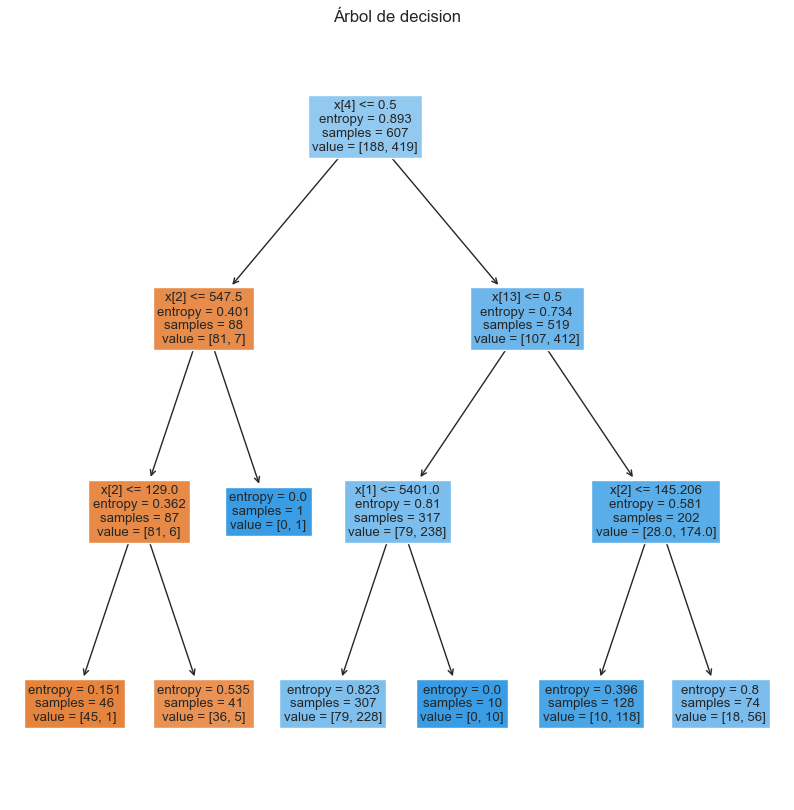

In [71]:
plt.figure(figsize=(10, 10))
#tree.plot_tree(tree_s)
tree.plot_tree(tree_s, filled=True)
plt.title("Árbol de decision")
plt.show()

In [73]:
nombres_columnas

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Gender',
 'Married',
 'Dependents_0',
 'Dependents_1',
 'Dependents_2',
 'Education',
 'Self_Employed',
 'Property_Area_Rural',
 'Property_Area_Semiurban',
 'Loan_Status']

In [75]:
accuracy_tree = tree_s.score(X, Y)
#print("Precisión en el conjunto de prueba:", accuracy_tree)
#print(colored(f"Precisión en el conjunto de prueba:{accuracy_tree}", "light_blue", attrs=['reverse'] ))
#accuracy_treeT = cross_val_score(X_train, Y_train)
accuracy_treeCV = cross_val_score(tree_s, X, Y, cv=loo).mean()
print(colored(f"Accuracy en el conjunto de entrenamiento:{accuracy_tree}", "magenta", attrs=['reverse'] ))
#print(colored(f"Accuracy en el conjunto de prueba:{accuracy_tree}", "light_magenta", attrs=['reverse'] ))
print(colored(f"Accuracy cv:{accuracy_treeCV}", "light_magenta", attrs=['reverse'] ))

Accuracy en el conjunto de entrenamiento:0.8138385502471169
Accuracy cv:0.8088962108731467


### <font color=#21610B>  Bosque aleatorio </font>

Un Random Forest es un meta-estimador que ajusta varios clasificadores de árboles de decisión en diferentes submuestras del conjunto de datos y usa el promedio para mejorar la precisión predictiva y controlar el sobreajuste. 


Utiliza un enfoque de bagging (bootstrap aggregation), donde se construyen varios árboles de manera independiente, cada uno entrenado con una submuestra aleatoria del conjunto de datos. Luego, sus predicciones se combinan (promedio en regresión o votación en clasificación).

Fuente: https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [78]:
#----------------- Random forest-------------------
#--------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
parametros = {
    #'random_state': [0,1,2,3],
    'max_depth': [5,10,20,30], #(regularizar)
    'ccp_alpha': np.linspace(0, 0.5, 4), #poda
    'n_estimators': [2,10,20,30, 100]
}
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=parametros, scoring='accuracy', cv=10, n_jobs = -1)
# Ajustar el modelo a los datos
grid_search.fit(X, Y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.        , 0.16666667, 0.33333333, 0.5       ]),
                         'max_depth': [5, 10, 20, 30],
                         'n_estimators': [2, 10, 20, 30, 100]},
             scoring='accuracy')

In [79]:
rf_cvbest = grid_search.best_estimator_
rf_cvbest

RandomForestClassifier(max_depth=5, n_estimators=20)

In [80]:
parms = grid_search.best_params_
rf_s = RandomForestClassifier(max_depth = parms['max_depth'], n_estimators = parms['n_estimators'])
rf_s.fit(X,Y)

RandomForestClassifier(max_depth=5, n_estimators=20)

In [81]:
#accuracy_rf = rf_s.score(X_test, Y_test)
accuracy_rfT = rf_s.score(X, Y)
accuracy_rfCV = cross_val_score(rf_s, X, Y, cv = loo).mean()
print(colored(f"Accuracy en el conjunto de entrenamiento:{accuracy_rfT}", "magenta", attrs=['reverse'] ))
print(colored(f"Accuracy en el conjunto de prueba:{accuracy_rfCV}", "light_magenta", attrs=['reverse'] ))

Accuracy en el conjunto de entrenamiento:0.8187808896210873
Accuracy en el conjunto de prueba:0.8072487644151565


La característica de mayor importancia fue: Credit_History


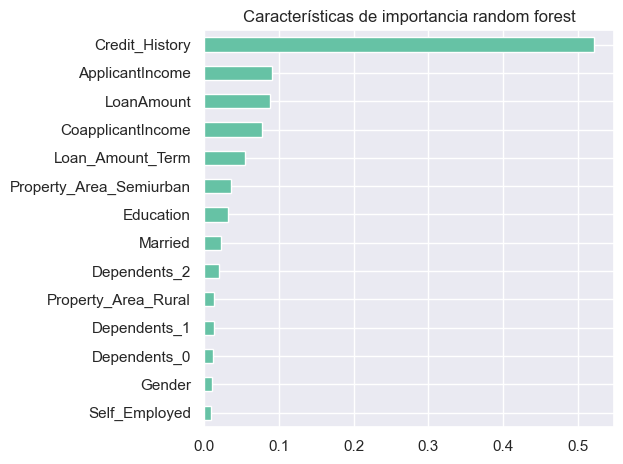

In [82]:
# Código de adaptado de scikitlearn 
# https://scikit-learn.org/1.4/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

# Obtención de importancias de características
importances = rf_cvbest.feature_importances_
#std = np.std([rf_cvbest.feature_importances_ for tree in rf_cvbest.estimators_], axis=0)
# 'rf_cvbest.estimators_'  contiene todos los árboles que componen el modelo de Random Forest.
# Se crea una Serie de pandas que almacena las importancias de las características junto con sus nombres y 'sort._values' las ordena
forest_importances = pd.Series(importances, index=nombres_columnas[0:14]).sort_values(ascending=True)
fig, ax = plt.subplots()
#forest_importances.plot.barh(yerr=std, ax=ax)
forest_importances.plot.barh(ax=ax)
# 'yerr' es un argumento que permite añadir barras de error que representan la variación en los valores que se están graficando
ax.set_title("Características de importancia random forest")
#ax.set_ylabel("Mean decrease in impurity") # reducción media de impureza 
fig.tight_layout()
print(colored(f"La característica de mayor importancia fue: {forest_importances.index[-1]}", "light_yellow", attrs=['reverse'] ))

### <font color=#21610B> Gradient Boosting Classifier </font>
Este algoritmo construye un modelo aditivo de manera secuencial en etapas, permitiendo la optimización de funciones de pérdida diferenciables arbitrarias. En cada etapa, se ajustan n_classes_ árboles de regresión sobre el gradiente negativo de la función de pérdida, por ejemplo, la pérdida logarítmica binaria o multiclasificación. La clasificación binaria es un caso especial donde solo se induce un único árbol de regresión.

Utiliza un enfoque de boosting, donde los árboles se entrenan de manera secuencial. Cada nuevo árbol se ajusta a los errores (residuos) del modelo anterior, tratando de corregir las predicciones incorrectas. Esto hace que los árboles en un modelo de boosting estén dependientemente relacionados, en lugar de ser independientes como en un Random Forest.

Fuente: https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html 


In [84]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
parametros = {
    'loss' : ['log_loss','exponential'], #deviance no está en todas las versiones de python
    #'random_state': [0,1,2,3],
    'max_depth': [2, 3, 5, 10,20],
    #'ccp_alpha': np.linspace(0.1, 0.5, 4),
    'learning_rate': [0.001, 0.1, 1 ], 
    'n_estimators': [5, 20,30, 100]
}

grid_search = GridSearchCV(estimator=gbc, param_grid=parametros, scoring='accuracy', cv=10, n_jobs =-1)
grid_search.fit(X, Y)
gbc_cvbest = grid_search.best_estimator_
gbc_cvbest

GradientBoostingClassifier(max_depth=2, n_estimators=5)

In [85]:
parms = grid_search.best_params_
gbc_s = GradientBoostingClassifier(max_depth = parms['max_depth'], n_estimators = parms['n_estimators'], loss = parms['loss'] )
gbc_s.fit(X,Y)

GradientBoostingClassifier(max_depth=2, n_estimators=5)

In [87]:
#accuracy_gbc = gbc_s.score(X_test, Y_test)
accuracy_gbcT = gbc_s.score(X, Y)
accuracy_gbcCV = cross_val_score(gbc_s, X, Y, cv = loo).mean()
print(colored(f"Accuracy en el conjunto de entrenamiento:{accuracy_gbcT}", "magenta", attrs=['reverse'] ))
print(colored(f"Accuracy CV:{accuracy_gbcCV}", "light_magenta", attrs=['reverse'] ))

Accuracy en el conjunto de entrenamiento:0.8138385502471169
Accuracy CV:0.8105436573311368


La característica de mayor importancia fue: Credit_History


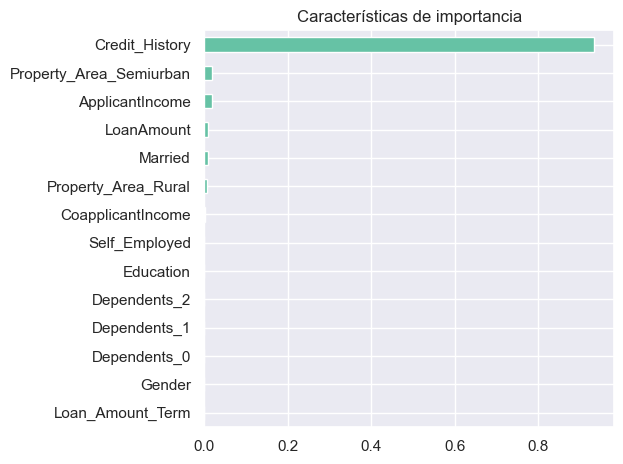

In [90]:
importances = gbc_cvbest.feature_importances_
std = np.std([gbc_cvbest.feature_importances_ for tree in gbc_cvbest.estimators_], axis=0)
gbc_importances = pd.Series(importances, index=nombres_columnas[0:14]).sort_values(ascending=True)
fig, ax = plt.subplots()
gbc_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Características de importancia")
#ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
print(colored(f"La característica de mayor importancia fue: {gbc_importances.index[-1]}", "light_yellow", attrs=['reverse'] ))

###  <font color=#21610B>  XGBoost </font>
Versión más eficiente y mejorada de Gradient Boosting

In [94]:
import xgboost as xgb

xgbclf = xgb.XGBClassifier()
parametros = {
    'max_depth': [5,10,20,30, 100],
    'learning_rate': [0.001, 0.1, 1 ],
    'n_estimators': [20, 100, 150]
}

grid_search = GridSearchCV(estimator = xgbclf, param_grid = parametros, scoring='accuracy', cv=10, n_jobs =-1)
grid_search.fit(X, Y)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.1, 1],
                         'max_depth': [5, 10, 20, 30, 100],
                         'n_estimators': [20, 100, 150]},
             scoring='accuracy')

In [105]:
xgb_cvbest = grid_search.best_estimator_
xgb_cvbest

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [107]:
parms = grid_search.best_params_
xgb_s = xgb.XGBClassifier(max_depth = parms['max_depth'], n_estimators = parms['n_estimators'], learning_rate = parms['learning_rate'])
xgb_s.fit(X,Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [109]:
#accuracy_xgb = xgb_s.score(X_test, Y_test)
accuracy_xgbT = xgb_s.score(X, Y)
accuracy_xgbCV = cross_val_score(xgb_s, X,Y, cv = loo).mean()
print(colored(f"Accuracy en el conjunto de entrenamiento:{accuracy_xgbT}", "magenta", attrs=['reverse'] ))
print(colored(f"Accuracy cv:{accuracy_xgbCV}", "light_magenta", attrs=['reverse'] ))

Accuracy en el conjunto de entrenamiento:0.8220757825370676
Accuracy cv:0.8088962108731467


La característica de mayor importancia fue: Credit_History


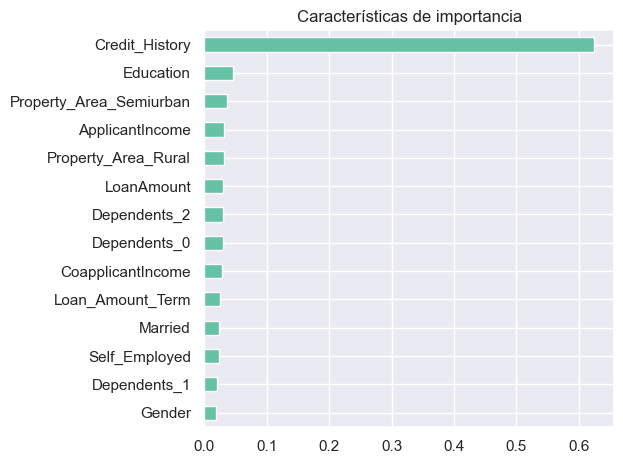

In [110]:
importances = xgb_cvbest.feature_importances_
#std = np.std([xgb_cvbest.feature_importances_ for tree in xgb_cvbest.estimators_], axis=0)
xgb_importances = pd.Series(importances, index=nombres_columnas[0:14]).sort_values(ascending=True)
fig, ax = plt.subplots()
xgb_importances.plot.barh(ax=ax)
ax.set_title("Características de importancia")
#ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
print(colored(f"La característica de mayor importancia fue: {xgb_importances.index[-1]}", "light_yellow", attrs=['reverse'] ))

### <font color=#21610B> Votación de modelos </font>

- **Votación dura**: Cada modelo da una predicción discreta y la predicción final se toma de acuerdo a la mayoría de los votos. 
- **Votación suave**: Cada modelo da una probabilidad para cada clase y la predicción final se elige tomando la clase que tenga la suma de las probabilidades de todos los modelos más alta.

In [113]:
#--------------- Votación dura -------------
#-------------------------------------------
rf = rf_s
gb = gbc_s 
# VotingClassifier con una lista de tuplas para los estimadores
voting = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='hard')

# Los parámetros son vectores
parametros = {'weights': [[1, 1], [1, 5], [5,1],[0.2,3],[3,0.2], [0.5,0.5], [100,1], [1,100]]}


grid_search4 = GridSearchCV(estimator=voting, param_grid=parametros, scoring='accuracy', cv=10, n_jobs=-1)

# Ajustar la búsqueda en cuadrícula a los datos
grid_search4.fit(X, Y)

vot_dura = grid_search4.best_estimator_

In [115]:
print(vot_dura)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=20)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=2,
                                                         n_estimators=5))],
                 weights=[1, 5])


In [117]:
parms = grid_search4.best_params_
votd_s = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='hard', weights = parms['weights'])
votd_s.fit(X,Y) # si es necesario

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=20)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=2,
                                                         n_estimators=5))],
                 weights=[1, 5])

In [119]:
#accuracy_vd = votd_s.score(X_test, Y_test)
accuracy_vdT = votd_s.score(X, Y)
accuracy_vdCV = cross_val_score(votd_s, X,Y, cv=loo).mean()
print(colored(f"Accuracy en el conjunto de entrenamiento:{accuracy_vdT}", "magenta", attrs=['reverse'] ))
print(colored(f"Accuracy CV:{accuracy_vdCV}", "light_magenta", attrs=['reverse'] ))

Accuracy en el conjunto de entrenamiento:0.8138385502471169
Accuracy CV:0.8105436573311368


In [120]:
#--------------- Votación suave ----------------
#-----------------------------------------------
rf = rf_s
gb = gbc_s 
# VotingClassifier con una lista de tuplas para los estimadores
voting = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft')

# Los parámetros son vectores
parametros = {'weights': [[1, 1], [1, 5], [5,1],[0.2,3],[3,0.2], [0.5,0.5], [100,1], [1,100]]}


grid_search4 = GridSearchCV(estimator=voting, param_grid=parametros, scoring='accuracy', cv=10, n_jobs=-1)

# Ajustar la búsqueda en cuadrícula a los datos
grid_search4.fit(X, Y)

vot_suave = grid_search4.best_estimator_
print(vot_suave)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=20)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=2,
                                                         n_estimators=5))],
                 voting='soft', weights=[1, 1])


In [121]:
parms = grid_search4.best_params_
vots_s = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft', weights = parms['weights'])
vots_s.fit(X,Y)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=20)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=2,
                                                         n_estimators=5))],
                 voting='soft', weights=[1, 1])

In [122]:
#accuracy_vs = vots_s.score(X_test, Y_test)
accuracy_vsT = vots_s.score(X, Y)
accuracy_vsCV = cross_val_score(vots_s, X, Y, cv = loo).mean()
print(colored(f"Accuracy en el conjunto de entrenamiento:{accuracy_vsT}", "magenta", attrs=['reverse'] ))
print(colored(f"Accuracy CV:{accuracy_vsCV}", "light_magenta", attrs=['reverse'] ))

Accuracy en el conjunto de entrenamiento:0.8154859967051071
Accuracy CV:0.8105436573311368


In [127]:
# Verificando
#np.max(Y_train),np.max(Y_test), np.max(Y_val)

### <font color =#FF8000> Comparando modelos </font>

In [130]:
print(colored('COMPARACIÓN DE MODELOS', 'light_yellow', attrs = ['reverse']))
print('{0:^20s} {1:^15s} {2:^10s}'.format('Modelo','acc D_train','acc CV'))
print('_______________________________________________')
print('{0:^20s} {1:10.5f} {2:15.5f}'.format('Regresión logística',accuracy_LT,accuracy_LCV))
print('{0:^20s} {1:10.5f} {2:15.5f}'.format('Regresión ridge',accuracy_ridgeT,accuracy_ridgeCV))
print('{0:^20s} {1:10.5f} {2:15.5f}'.format('Random tree',accuracy_tree,accuracy_treeCV))
print('{0:^20s} {1:10.5f} {2:15.5f}'.format('Random forest',accuracy_rfT,accuracy_rfCV))
print('{0:^20s} {1:10.5f} {2:15.5f}'.format('Gradient Boosting',accuracy_gbcT,accuracy_gbcCV))
print('{0:^20s} {1:10.5f} {2:15.5f}'.format('XGBoost',accuracy_xgbT,accuracy_xgbCV))
print('{0:^20s} {1:10.5f} {2:15.5f}'.format('Votación dura',accuracy_vdT,accuracy_vdCV))
print('{0:^20s} {1:10.5f} {2:15.5f}'.format('Votación suave',accuracy_vsT,accuracy_vsCV))
print('_______________________________________________')
print(colored('Por simplicidad del modelo, podríamos utilizar la regresión logística lasso', 'light_green', attrs = ['reverse']))

COMPARACIÓN DE MODELOS
       Modelo          acc D_train     acc CV  
_______________________________________________
Regresión logística     0.81054         0.81068
  Regresión ridge       0.81219         0.81054
    Random tree         0.81384         0.80890
   Random forest        0.81878         0.80725
 Gradient Boosting      0.81384         0.81054
      XGBoost           0.82208         0.80890
   Votación dura        0.81384         0.81054
   Votación suave       0.81549         0.81054
_______________________________________________
Por simplicidad del modelo, podríamos utilizar la regresión logística lasso


### <font color=#21610B>  Red neuronal </font>

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [134]:
# trabajamos en el mps
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" #para usar metal
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [136]:
# Definimos la red neuronal 
class Red1(nn.Module):
    def __init__(self, in_features = 14, h1 = 150, h2 = 150, h3 = 150, h4 = 125, h5 = 10,out_features = 1):
        super(Red1, self).__init__()        
        # Todas las capas son fully connected (todo alimenta todo)
        self.fc1 = nn.Linear(in_features, h1) # De la capa de input a la hidden1 (14x150)
        self.fc2 = nn.Linear(h1,h2) # De la capa hidden 1 a la hidden 2 (150x150)
        self.fc3 = nn.Linear(h2,h3) # De la capa hidden 2 a la hidden 3 (150x150)
        self.fc4 = nn.Linear(h3,h4) # De la capa hidden 3 a la hidden 4 (150x125)
        self.fc5 = nn.Linear(h4,h5) # De la capa hidden 4 a la hidden 5 (125x10)
        self.out = nn.Linear(h5, out_features) # De la hidden 5 a la out (10x1)
    def forward(self, x): # Definimos una función que mueva todo hacia adelante
        x = self.fc1(x) # Capa 1 (con la x vamos haciendo las composiciones)
        x = F.relu(x) # Función de activación ReLu (Rectified Linear Unit)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = F.sigmoid(self.out(x))  # función sigmoide a la salida de la capa self.out(x), interpretación de probabilidad
        
        return x

In [147]:
# Parámetros
model = Red1()
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Numero de parametros del modelo: {n_params}')

Numero de parametros del modelo: 67696


In [138]:
# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

In [140]:
# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y, dtype=torch.float32)

# Crear DataLoader para los conjuntos de entrenamiento y validación
train_data = TensorDataset(X_train_tensor, Y_train_tensor)


# DataLoaders: manejar lotes y barajar los datos
batch_size = 32  # Tamaño del lote
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)



**nn.BCELoss():** Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities.

<img src="bc.png" width="500" height="500"/>
Fuentes: 

- https://pytorch.org/docs/stable/nn.html#loss-functions 
- https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

Entrenamos con todo el conjunto de datos:

In [163]:
# Inicializar el modelo
num_features = len(nombres_columnas)  # Número de características 
model = Red1(14)

# Definir la función de pérdida-Binary Cross-Entropy- cuando usamos sigmoide
loss_fn = nn.BCELoss()

# Definir el optimizador (Adam es una opción popular)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Número de épocas
EPOCHS = 10000

def train_model(model, train_loader, loss_fn, optimizer, EPOCHS):
    losses = []
    accs = []
    for epoch in range(EPOCHS):
        model.train()  # Modo de entrenamiento
        running_loss = 0.0
        for inputs, labels in train_loader: # Entrenamiento del modelo por bathces
            optimizer.zero_grad()  # Limpiar los gradientes          
            outputs = model(inputs) # Pasar los datos a través del modelo
            loss = loss_fn(outputs.squeeze(), labels) # Calcular la pérdida 
            loss.backward() #backpropagation
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader) # Promedio de la pérdida para esta época
        losses.append(avg_loss)
        model.eval()  # Modo de evaluación para el val_data
        correct = 0 # iniciamos lo que clasifica bien
        total = 0 # total por cada batche
        with torch.no_grad():  # Desactivar cálculo de gradientes/no los necesitamos para eval
            for inputs, labels in train_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()  # Clasificación binaria
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total # Accuracy de validación
        accs.append(accuracy)
        if epoch % 1000 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}], Loss en el train: {avg_loss:.4f} Accuracy en el train {accuracy: .4f}")
    return losses, accs
# Llamamos a la función de entrenamiento con el conjunto de validación también
entrenamiento = train_model(model, train_loader,loss_fn, optimizer, EPOCHS)

Epoch [0/10000], Loss en el train: 21.1632 Accuracy en el train  0.6903
Epoch [1000/10000], Loss en el train: 0.5900 Accuracy en el train  0.7035
Epoch [2000/10000], Loss en el train: 0.5638 Accuracy en el train  0.7117
Epoch [3000/10000], Loss en el train: 0.5305 Accuracy en el train  0.7166
Epoch [4000/10000], Loss en el train: 0.5047 Accuracy en el train  0.7117
Epoch [5000/10000], Loss en el train: 0.4703 Accuracy en el train  0.7348
Epoch [6000/10000], Loss en el train: 0.4283 Accuracy en el train  0.7891
Epoch [7000/10000], Loss en el train: 0.5260 Accuracy en el train  0.7611
Epoch [8000/10000], Loss en el train: 0.3892 Accuracy en el train  0.8418
Epoch [9000/10000], Loss en el train: 0.3735 Accuracy en el train  0.8171


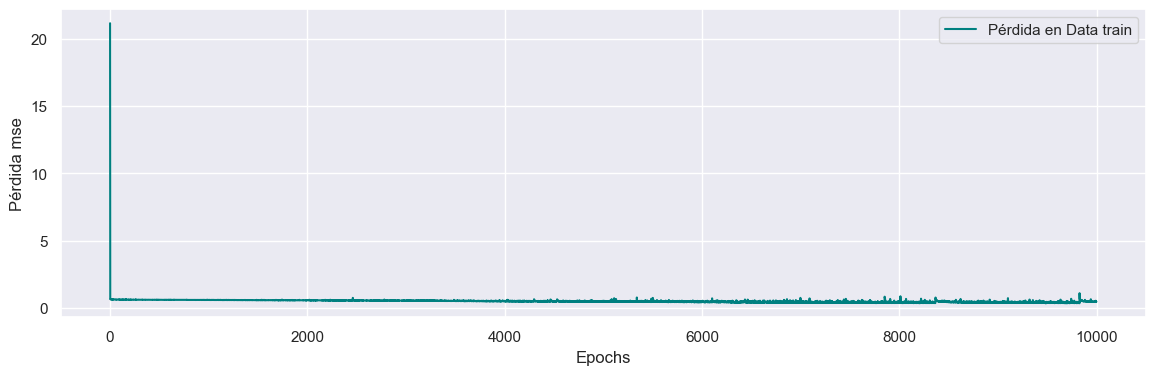

In [165]:
plt.figure(figsize=(14, 4))
plt.plot(range(EPOCHS), entrenamiento[0], color = 'teal', label='Pérdida en Data train')
plt.ylabel('Pérdida mse')
plt.xlabel('Epochs')
plt.legend()
plt.show()

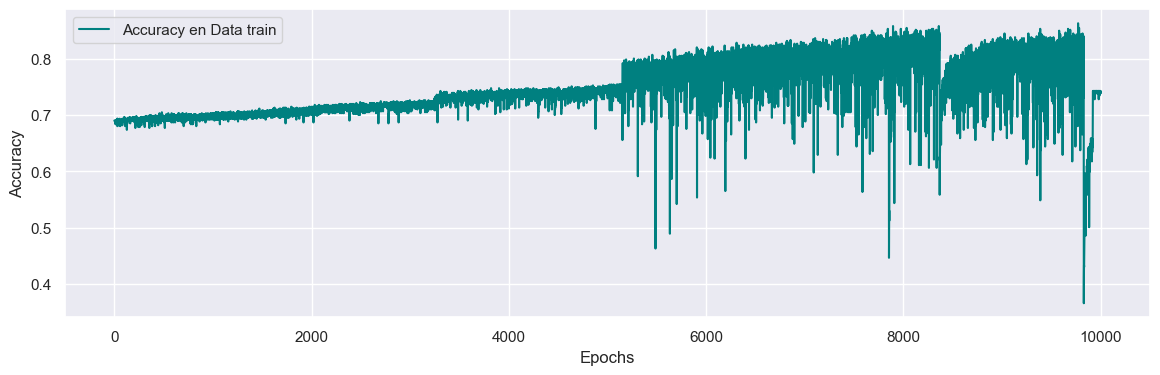

In [167]:
plt.figure(figsize=(14, 4))
plt.plot(range(EPOCHS), entrenamiento[1], color = 'teal', label='Accuracy en Data train')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [169]:
with torch.no_grad():
    predicted = model(X_train_tensor) 

In [189]:
# Función de evaluación
def eval_model(model, val_loader):
    model.eval()  # Modo de evaluación
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()  # Clasificación binaria
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    #print(f'Accuracy: {accuracy:.4f}')
    return accuracy
    
acc_train = eval_model(model, train_loader)
acc_train

0.7397034596375618

In [195]:
# Configurar KFold
kf = KFold(n_splits=6, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X_train_tensor):
    X_train, X_test = X_train_tensor[train_index], X_train_tensor[test_index]
    Y_train, Y_test = Y_train_tensor[train_index], Y_train_tensor[test_index]
    #print(f"Pliegue {fold+1}/{kf.get_n_splits()}")
    train_data = TensorDataset(X_train, Y_train)
    val_data = TensorDataset(X_test, Y_test)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
    # Evaluar el modelo en el pliegue de validación
    accuracy = eval_model(model, val_loader)
    accuracies.append(accuracy)
    print(f"Accuracy en el pliegue {1}: {accuracy:.4f}")
# Promediar el accuracy de todos los pliegues
avg_accuracy = np.mean(accuracies)
print(f"Accuracy promedio de validación cruzada: {avg_accuracy:.4f}")

Accuracy en el pliegue 1: 0.8235
Accuracy en el pliegue 1: 0.7525
Accuracy en el pliegue 1: 0.7822
Accuracy en el pliegue 1: 0.6931
Accuracy en el pliegue 1: 0.6931
Accuracy en el pliegue 1: 0.6931
Accuracy promedio de validación cruzada: 0.7396


Se realiza **validación** cruzada para hacer el entrenamiento y obtener un error de generalización promedio.

In [203]:
# Configurar KFold
kf = KFold(n_splits=6, shuffle=True, random_state=42)
accuracies = []
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()
       
for train_index, test_index in kf.split(X_train_tensor):
    X_train, X_test = X_train_tensor[train_index], X_train_tensor[test_index]
    Y_train, Y_test = Y_train_tensor[train_index], Y_train_tensor[test_index]
    #print(f"Pliegue {fold+1}/{kf.get_n_splits()}")
    train_data = TensorDataset(X_train, Y_train)
    val_data = TensorDataset(X_test, Y_test)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
    model.apply(reset_weights) # Reiniciar el modelo y el optimizador para cada fold
    optimizer = optim.SGD(model.parameters(), lr=0.001)  # O el optimizador
    losses, accs = train_model(model, train_loader, loss_fn, optimizer, EPOCHS)
    # Evaluar el modelo en el pliegue de validación
    accuracy = eval_model(model, val_loader)
    accuracies.append(accuracy)
    print(f"Accuracy en el fold {1}: {accuracy:.4f}")
# Promediar el accuracy de todos los pliegues
avg_accuracy = np.mean(accuracies)
print(f"Accuracy promedio de validación cruzada: {avg_accuracy:.4f}")

Reset trainable parameters of layer = Linear(in_features=14, out_features=150, bias=True)
Reset trainable parameters of layer = Linear(in_features=150, out_features=150, bias=True)
Reset trainable parameters of layer = Linear(in_features=150, out_features=150, bias=True)
Reset trainable parameters of layer = Linear(in_features=150, out_features=125, bias=True)
Reset trainable parameters of layer = Linear(in_features=125, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=1, bias=True)
Epoch [0/10000], Loss en el train: 1.3580 Accuracy en el train  0.6832
Epoch [1000/10000], Loss en el train: 0.6008 Accuracy en el train  0.6851
Epoch [2000/10000], Loss en el train: 0.5750 Accuracy en el train  0.7109
Epoch [3000/10000], Loss en el train: 0.5587 Accuracy en el train  0.7129
Epoch [4000/10000], Loss en el train: 0.5391 Accuracy en el train  0.7208
Epoch [5000/10000], Loss en el train: 0.5045 Accuracy en el train  0.7267
Epoch [6000/10000]

## <font color =#DA81F5> CONCLUSIÓN </font>

Dado que contamos con una base de datos pequeña, utilizamos validación cruzada para comparar el rendimiento de los modelos de regresión logística, árboles de decisión, y de ensambles. Los resultados sugieren que, por simplicidad, la regresión logística regularizada con Lasso es un buen candidato para predecir la aprobación del préstamo hipotecario. Por otra parte, al ajustar los modelos de ensamble, se notó que Credit_History es una variable determinante en la clasificación.

En el caso de la red neuronal, aunque podría ser mejorada, el accuracy promedio no estuvo cerca del accuracy del modelo logístico, además la red es un modelo considerablemente más complejo y es necesairio un mayor volumen de datos para generalizar bien. Además, la red neuronal tiene un costo computacional mucho mayor. Por lo tanto, dadas estas consideraciones, consideramos a la regresión logística preferible.